In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect = True)

In [6]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
lastDate = session.query(measurement.date).order_by(measurement.date.desc()).first()
lastDate

('2017-08-23',)

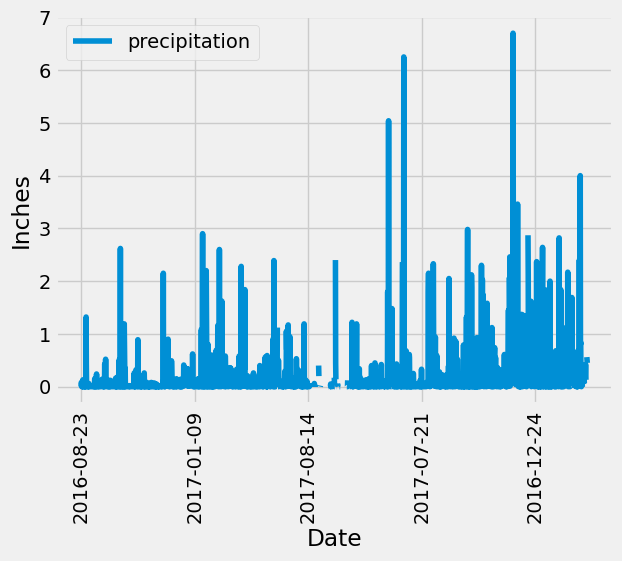

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
queryDate = dt.date(2017, 8, 23) - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
x = [measurement.date, measurement.prcp]
query = session.query(*x).filter(measurement.date >= queryDate).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
resultsDF = pd.DataFrame(query, columns=['date','precipitation'])
resultsDF.set_index("date", inplace = True)

# Sort the dataframe by date
resultsDF.sort_values(["date"], ascending = True)
resultsDF.head()

# Use Pandas Plotting with Matplotlib to plot the data
resultsDF.plot(x_compat = True) 
plt.xticks(rotation='90')
plt.xlabel("Date")
plt.ylabel("Inches")

plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
resultsDF.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset
session.query(station.id).count()

9

In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
x = [measurement.station, func.count(measurement.id)]
mostActive = session.query(*x).group_by(measurement.station).order_by(func.count(measurement.id).desc()).all()
mostActive

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
x = [func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)]
mostActiveData = session.query(*x).group_by(measurement.station).order_by(func.count(measurement.id).desc()).first()
mostActiveData

(54.0, 85.0, 71.66378066378067)

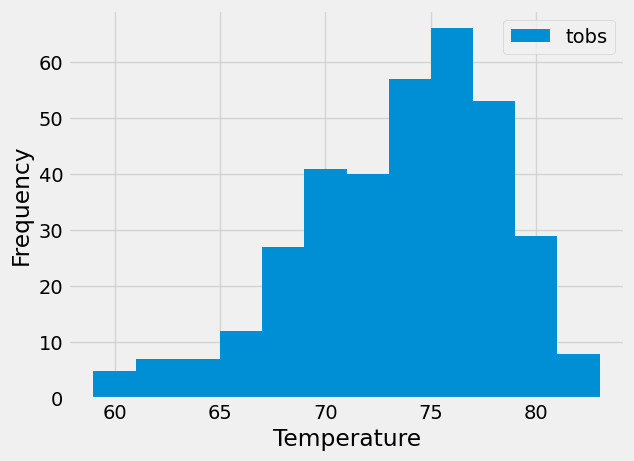

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
import datetime as dt
from pandas.plotting import table

query = session.query(measurement.tobs).filter(measurement.station == mostActive[0][0]).\
    filter(measurement.date >= queryDate).all()
temperatures = list(np.ravel(query))

sel = [station.station, station.name, station.latitude, station.longitude, station.elevation]
query = session.query(*sel).all()
stations = pd.DataFrame(query, columns=['Station','Name','Latitude','Longitude','Elevation'])

stationname = stations.loc[stations["Station"] == mostActive[0][0],"Name"].tolist()[0]

# n, bins, patches = plt.hist(temperatures, bins=12,alpha=0.7, rwidth=1.0,label='tobs')
plt.hist(temperatures, bins=12,rwidth=1.0,label='tobs')
plt.grid(axis='both', alpha=0.75)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()

# Close Session

In [16]:
session.close()